# Fine-tuning a Vision Transformer Model With a Custom Biomedical Dataset

## Dataset Info
The custom dataset is hand-made, containing 780 images with 3 classes (benign, malignant, normal). 

![attachment:datasetinfo.png](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/102d6c23e6cc24db857fbc60186461ded6cdfb75/datasetinfo.png)

## Model Info
The model we fine-tune will be Google's [`"vit-large-patch16-224"`](https://huggingface.co/google/vit-large-patch16-224). It is trained on ImageNet-21k (14M images, 21.843 classes), and fine-tuned on ImageNet 2012 (1M images, 1.000 classes) at resolution 224x224. Google has several other ViT models with different image sizes and patches.

Let's get started.

In [ ]:
!pip install datasets transformers accelerate torch scikit-learn matplotlib wandb

## Dataset Preparation
Datasets library automatically pulls images and classes from the dataset.

In [3]:
from datasets import load_dataset

dataset = load_dataset("emre570/breastcancer-ultrasound-images")
dataset

Generating test split: 100%|██████████| 156/156 [00:00<00:00, 920.43 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

We got our dataset. But we don't have a validation set. To create the validation set, we will calculate the size of the validation set as a fraction of the training set based on the size of the test set. Then we split the training dataset into new training and validation subsets.

In [4]:
# Get the numbers of each set
test_num = len(dataset["test"])
train_num = len(dataset["train"])

val_size = test_num / train_num

train_val_split = dataset["train"].train_test_split(test_size=val_size)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

We got our seperated train set. Let's merge them with test set.

In [5]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": train_val_split["train"],
    "validation": train_val_split["test"],
    "test": dataset["test"]
})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

Perfect! Our dataset is ready. Let's assign subsets to different variables. We will use them later for easy reference.

In [6]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

We can see the image is a PIL.Image with a label associated with it.

In [7]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=552x483>,
 'label': 0}

We can also see the features of train set.

In [8]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

Let's show one image from each class from dataset.

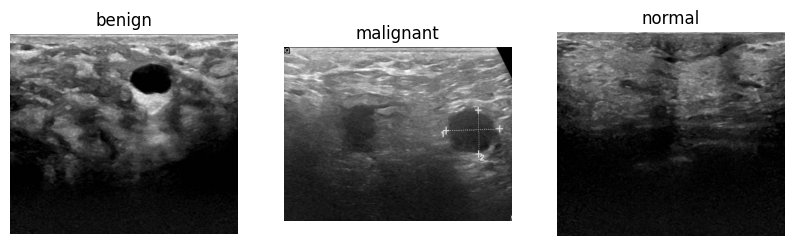

In [9]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(10, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features['label'].names[sample['label']]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features['label'].names), len(shown_labels) + 1)
        plt.imshow(sample['image'])
        plt.title(label)
        plt.axis('off')
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features['label'].names):
            break

plt.show()

## Data Processing
The dataset is ready. But we are not ready for fine-tuning. We will follow this procedures respectively:

- **Label Mapping:** We convert between label IDs and their corresponding names, useful for model training and evaluation.

- **Image Processing:** Then, we utilize the ViTImageProcessor to standardize input image sizes and applies normalization specific to the pretrained model. Also, will define different transformations for training, validation, and testing to improve model generalization using torchvision.

- **Transform Functions:** Implement functions to apply the transformations to the dataset, converting images to the required format and dimensions for the ViT model.

- **Data Loading:** Set up a custom collate function to properly batch images and labels, and create a DataLoader for efficient loading and batching during model training.

### Label Mapping

In [10]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label, id2label[train_ds[0]['label']]

({0: 'benign', 1: 'malignant', 2: 'normal'}, 'benign')

### Image Processing

In [11]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

c:\Users\linux Store\myvenv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\linux Store\.cache\huggingface\hub\models--google--vit-large-patch16-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [21]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Resize

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose([        
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])
val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])
test_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

### Create transform functions

In [22]:
def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_test_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

### Apply transform functions to each set

In [23]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [24]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

In [25]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=552x483>,
 'label': 0,
 'pixel_values': tensor([[[-0.5137, -0.4667, -0.4353,  ..., -0.3255, -0.2784, -0.2314],
          [-0.4667, -0.4431, -0.4431,  ..., -0.3176, -0.2157, -0.1451],
          [-0.4745, -0.4588, -0.4510,  ..., -0.2235, -0.0902, -0.0196],
          ...,
          [-0.9686, -0.9765, -0.9843,  ..., -0.9451, -0.9765, -0.9843],
          [-0.9608, -0.9922, -1.0000,  ..., -0.9529, -0.9843, -0.9922],
          [-0.9451, -0.9765, -0.9922,  ..., -0.9608, -0.9765, -0.9922]],
 
         [[-0.5137, -0.4667, -0.4353,  ..., -0.3255, -0.2784, -0.2314],
          [-0.4667, -0.4431, -0.4431,  ..., -0.3176, -0.2157, -0.1451],
          [-0.4745, -0.4588, -0.4510,  ..., -0.2235, -0.0902, -0.0196],
          ...,
          [-0.9686, -0.9765, -0.9843,  ..., -0.9451, -0.9765, -0.9843],
          [-0.9608, -0.9922, -1.0000,  ..., -0.9529, -0.9843, -0.9922],
          [-0.9451, -0.9765, -0.9922,  ..., -0.9608, -0.9765, -0.9922]],


Looks like we converted our pixel values into tensors. 

### Data Loading

In [26]:
import torch
from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

### Batch Preparation

In [27]:
batch = next(iter(train_dl))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


Perfect! Now we are ready for fine-tuning process.

## Fine-tuning the Model
Now we will configure and fine-tune the model. We started by initializing the model with specific label mappings and pre-trained settings, adjusting for size mismatches. Training parameters are set up to define the model's learning process, including the save strategy, batch sizes, and training epochs, with results logged via Weights & Biases. Hugging Face Trainer will then instantiate to manage the training and evaluation, utilizing a custom data collator and the model's built-in processor. Finally, after training, the model's performance is evaluated on a test dataset, with metrics printed to assess its accuracy.

First, we call our model.

In [29]:
from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There is a subtle detail in here. The `ignore_mismatched_sizes` parameter.

When you fine-tune a pre-trained model on a new dataset, sometimes the input size of your images or the model architecture specifics (like the number of labels in the classification layer) might not match exactly with what the model was originally trained on. This can happen for various reasons, such as when using a model trained on one type of image data (like natural images from ImageNet) on a completely different type of image data (like medical images or specialized camera images).

Setting `ignore_mismatched_sizes` to `True` allows the model to adjust its layers to accommodate size differences without throwing an error. 

For example, the number of classes this model is trained on is 1000, which is `torch.Size([1000])` and it expects an input with `torch.Size([1000])` classes. Our dataset has 3, which is `torch.Size([3])` classes. If we give it directly, it will raise an error because the class numbers do not match.

Then, define training arguments from Google for this 


(Optional) Note that the metrics will be saved in Weights & Biases because we set the `report_to` parameter to `wandb`. W&B will ask you for an API key, so you should create an account and an API key. If you don't want, you can remove `report_to` parameter.

In [35]:
import tensorflow as tf
from tensorflow.keras import layers 
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir = "output-models",
    save_total_limit=2,
    report_to="wandb",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=40,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

c:\Users\linux Store\myvenv\Lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



We can now begin the fine-tuning process with 

In [36]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Paste an API key from your profile and hit e

| Epoch | Training Loss | Validation Loss | Accuracy |
|-------|---------------|-----------------|----------|
| 40    | 0.174700      | 0.596288        | 0.903846 |

The fine-tuning process is done. Let's continue with evaluating the model to test set.

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

That's great! Let's visualize the results.

## Results
We made the fine-tuning. Let's see how our model predicted the classes using scikit-learn's Confusion Matrix Display and show Recall Score.

### confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### Recall score

In [ ]:
from sklearn.metrics import recall_score

# Calculate the recall scores
# 'None' calculates recall for each class separately
recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
    print(f'Recall for {label}: {score:.2f}')